In [1]:
import matplotlib.pyplot as plt
import numpy as np


In [2]:
class CalculatorTheoreticalSCCT:
    # python version of https://github.com/wavefancy/scct/blob/master/sources/TheoreticalRatio/version1.1/src/CalculatorV5.java
    def __init__(self, dn=None, an=None):
        self.BT = None
        self.dn = dn
        self.an = an
        if dn is not None and an is not None:
            self.set_individual(dn, an)

    def set_individual(self, dn, an):
        # * Set the number of individuals for derived and ancestral group
        
        self.dn = dn
        self.an = an
        self.BT = [[0.0 for _ in range(an + 1)] for _ in range(dn + 1)]
        # calculate expectation of branch length
        for i in range(1, dn + 1):
            for j in range(1, an + 1):
                if i == 1 and j == 1:
                    # not used
                    self.BT[i][j] = 1.0
                else:
                    total = i + j
                    self.BT[i][j] = 2.0 / (total * (total - 1))



    def normal_total_tree_len(self, n):
        # Compute total tree length for normal coalescent model.
        # n,  total leaf number.
	    # returns total tree length.

        total = 0.0
        for i in range(2, n + 1):
            total += 2.0 / (i - 1)
        return total

    def get_expectation(self, dn, an):
        if dn < 1 or an < 1: # monomorphic, invalid, ...
            return float('nan')  
        self.set_individual(dn, an)
        return self._get_expectation()

    def _get_expectation(self):
        dn, an = self.dn, self.an

        # tree length for iteration
        # (numpy arrays?)

        tl_D = 0.0
        tl_A = 0.0

        # test probability
        p = [[0.0 for _ in range(an + 1)] for _ in range(dn + 1)]
        p[dn][an] = 1.0


        # for the end condition is (1,a). (1,a+1) will not go to (1,a)
        for d in range(dn, 1, -1):
            for a in range(an, 0, -1):
                prob = p[d][a]
                if prob == 0.0:
                    continue
                total = d + a
                l = self.BT[d][a]

                tL = (prob * (d + 1)) / total if d - 1 >= 1 else 0.0
                tR = (prob * (a - 1)) / total if a - 1 >= 1 else 0.0

                if d - 1 >= 1:
                    p[d - 1][a] += tL
                if a - 1 >= 1:
                    p[d][a - 1] += tR

                temp = tL + tR
                tl_D += d * l * temp
                tl_A += a * l * temp

        # Compute the total branch length when reach (1,a)
        for a in range(1, an + 1):
            tl_A += self.normal_total_tree_len(a + 1) * p[1][a]

        if tl_A == 0.0:
            return float('inf')
        return tl_D / tl_A




In [3]:
import allel
import os
vcf_chr9 = os.path.join("examples", "data", "1KG.nea_den.chr9.example.vcf.gz")
ref_ind_file = os.path.join("examples", "data", "1KG.ref.samples.txt")
tgt_ind_file = os.path.join("examples", "data", "1KG.tgt.samples.txt")
src_ind_file = os.path.join("examples", "data", "1KG.src.samples.txt")


In [4]:
vcf_file_allel = allel.read_vcf(vcf_chr9)

In [5]:
genotypes = vcf_file_allel['calldata/GT']
genotype_array = allel.GenotypeArray(genotypes)


In [6]:
anc_allele_file = None
win_len = 50000
win_step = 50000
chr_name = "9"
vcf_file = vcf_chr9
ploidy = 2

In [7]:
from sai.utils.generators import SaiWindowDataGenerator
from sai.utils.generators import ChunkGenerator

In [8]:
def load_full_vcf(vcf_file: str,chr_name: str,ref_ind_file: str,tgt_ind_file: str,anc_allele_file: str = None,ploidy: int = 2,is_phased: bool = True,src_ind_file: str = None):
    import sai.utils.gaia_utils as gaia_utils
    ref_data, ref_samples, tgt_data, tgt_samples, src_data, src_samples = gaia_utils.read_data_src(vcf_file, ref_ind_file, tgt_ind_file, src_ind_file, anc_allele_file, is_phased)

    pos = tgt_data[chr_name]["POS"]


    ref_gts = ref_data[chr_name]["GT"]
    tgt_gts = tgt_data[chr_name]["GT"]
    if src_ind_file:
        src_gts = src_data[chr_name]["GT"]

    return ref_gts, src_gts, tgt_gts, pos

In [9]:
from numpy.lib.stride_tricks import sliding_window_view

In [10]:
def filter_zero_rows(gts, return_indices = False):

    zero_rows_mask = np.all(gts == 0, axis=1)

    zero_row_indices = np.where(zero_rows_mask)[0]


    filtered_arr = gts[~zero_rows_mask]

    if not return_indices:
        return filtered_arr
    else:
        return filtered_arr, zero_row_indices

In [11]:
def sample_scct(gts, central_snp=None, ploidy=2, is_phased=True, average_over_nonzero_unphased=False):
    # if index of central snp (for which the statistics is calculated) is not given, we choose the middle
    if not central_snp:
        central_snp = gts.shape[0]//2

    central_values = gts[central_snp, :]

    # this is in line with the original scct-implementation
    if ploidy == 1 or is_phased:
        snp_mask = central_values == 1

        subgroup_D = np.where(snp_mask)[0]
        subgroup_C = np.where(~snp_mask)[0]

    elif ploidy > 1 and not average_over_nonzero_unphased:

        mask_0 = central_values == 0
        mask_n = central_values == ploidy

        subgroup_D = np.where(mask_n)[0]
        subgroup_C = np.where(mask_0)[0]

    elif ploidy > 1 and average_over_nonzero_unphased:

        mask_0 = central_values == 0
        mask_n = central_values > ploidy

        subgroup_D = np.where(mask_n)[0]
        subgroup_C = np.where(mask_0)[0]


    # as calc_freq, but frequencies over individuals
    if ploidy == 1 or is_phased:
        return np.mean(gts, axis=0)
    else:
        return np.sum(gts, axis=0) / (gts.shape[0] * ploidy)


In [12]:
import numpy as np

def frequency_by_snp_group(gts, central_snp=None, ploidy=2, is_phased=True):
    """
    Groups samples by central SNP value and computes frequency of 1s per SNP (excluding central SNP).

    Parameters:
        gts (ndarray): Binary or multi-valued SNP matrix (shape: SNPs x Samples)
        central_snp (int, optional): Index of the SNP to group by. Defaults to center SNP.

    Returns:
        dict: value -> frequency vector (1s per SNP, central SNP excluded)
    """
    if central_snp is None:
        central_snp = gts.shape[0] // 2

    central_values = gts[central_snp, :]
    unique_vals = np.unique(central_values)

    # Indices of all rows except the central SNP
    other_snp_rows = np.delete(np.arange(gts.shape[0]), central_snp)

    freq_by_value = {}

    for val in unique_vals:
        # Select samples (columns) where central SNP == val
        sample_indices = np.where(central_values == val)[0]

        # Extract relevant part of the matrix (excluding central SNP row)
        submatrix = gts[other_snp_rows, :][:, sample_indices]

        # Compute frequency
        if ploidy == 1 or is_phased:
            freq = np.mean(submatrix, axis=1)
        else:
            freq =  np.sum(submatrix, axis=1) / (submatrix.shape[1] * ploidy)

        freq_by_value[val] = freq

    return freq_by_value


In [13]:
import numpy as np

def counts_by_snp_group(gts, central_snp=None, ploidy=2, is_phased=True):
    """
    Groups samples by central SNP value and computes frequency of 1s per SNP (excluding central SNP).

    Parameters:
        gts (ndarray): Binary or multi-valued SNP matrix (shape: SNPs x Samples)
        central_snp (int, optional): Index of the SNP to group by. Defaults to center SNP.

    Returns:
        dict: value -> frequency vector (1s per SNP, central SNP excluded)
    """
    if central_snp is None:
        central_snp = gts.shape[0] // 2

    central_values = gts[central_snp, :]
    unique_vals = np.unique(central_values)

    # Indices of all rows except the central SNP
    other_snp_rows = np.delete(np.arange(gts.shape[0]), central_snp)

    #freq_by_value = {}
    result_by_value = {}

    for val in unique_vals:
        # Select samples (columns) where central SNP == val
        sample_indices = np.where(central_values == val)[0]

        # Extract relevant part of the matrix (excluding central SNP row)
        submatrix = gts[other_snp_rows, :][:, sample_indices]

        count = np.sum(submatrix, axis=1)

        total_derived = np.sum(count)

        result_by_value[val] = {
            "per_snp_counts": count,
            "total_derived_mutations": total_derived
        }

    return result_by_value


In [14]:
def scct_counting_classical(gts, central_snp, return_counts=False):
    central_values = gts[central_snp, :]

    # this is in line with the original scct-implementation
    snp_mask = central_values == 1

    subgroup_D = np.where(snp_mask)[0]
    subgroup_C = np.where(~snp_mask)[0]

    other_snp_rows = np.delete(np.arange(gts.shape[0]), central_snp)

    #print("subgroups")
    #print(subgroup_D)
    #print(subgroup_C)

    submatrix_D = gts[other_snp_rows, :][:, subgroup_D]
    submatrix_C = gts[other_snp_rows, :][:, subgroup_C]
    
    count_D = np.sum(submatrix_D, axis=1)
    count_C = np.sum(submatrix_C, axis=1)

    if return_counts:
        return count_D, count_C

    #print("counts")
    #print(count_D)
    #print(count_C)

    sum_D = np.sum(count_D)
    sum_C = np.sum(count_C)

    return sum_D, sum_C

In [15]:
def sample_scct_phased(gts, central_snp=None, theoretical=True, gts_pos=None, full_vcf_gts=None, full_vcf_pos=None, set_alpha_1=False):
    # if index of central snp (for which the statistics is calculated) is not given, we choose the middle
    if not central_snp:
        central_snp = gts.shape[0]//2

    sum_D, sum_C = scct_counting_classical(gts, central_snp, return_counts=False)


    central_values_count = np.unique(gts[central_snp, :], return_counts=True)
    central_values_ancestral = central_values_count[1][0] 
    central_values_derived = central_values_count[1][-1] 


    if set_alpha_1:
        ratio_alpha = 1

    elif theoretical:
        theoretical_calculator = CalculatorTheoreticalSCCT()
        ratio_alpha = theoretical_calculator.get_expectation(central_values_derived, central_values_ancestral)
        print(f"theoretical ratio: {ratio_alpha}")

    else:
        central_pos = gts_pos[central_snp]


        full_vcf_gts_filtered, full_indices_filtered = filter_zero_rows(full_vcf_gts, return_indices=True)

        #full_vcf_pos_filtered = full_vcf_pos[full_indices_filtered]
        full_vcf_pos_filtered = np.delete(full_vcf_pos, full_indices_filtered, axis=0)
        
        central_index_full = np.where(np.array(full_vcf_pos_filtered) == int(central_pos))[0][0]

        sum_D_full, sum_C_full = scct_counting_classical(full_vcf_gts_filtered, central_index_full, return_counts=False)

        ratio_alpha = sum_D_full / sum_C_full

        print(f"empirical ratio: {ratio_alpha}")


    S = np.log(sum_D/(ratio_alpha*sum_C))

    return S

In [16]:
def sample_scct_freqs(gts, central_snp=None, ploidy=2, is_phased=True, average_over_nonzero_unphased=False):
    # if index of central snp (for which the statistics is calculated) is not given, we choose the middle
    if not central_snp:
        central_snp = gts.shape[0]//2

    central_values = gts[central_snp, :]
    unique_values = np.unique(central_values)

    value_to_indices = {
        val: np.where(central_values == val)[0]
        for val in unique_values
    }

    return value_to_indices

In [17]:
def scct_windows_from_bpwindows(gts, gts_pos, snp_window_size = 151, full_vcf_gts=None, full_vcf_pos=None, function_to_apply=sample_scct_phased, theoretical=True, central_snp=None, return_max=False):


    gts_filtered, gts_indices = filter_zero_rows(gts, return_indices=True)
    #gts_pos_filtered = gts_pos[gts_indices]
    gts_pos_filtered = np.delete(gts_pos, gts_indices, axis=0)

    # Check if window size is too large
    if gts_filtered.shape[0] < snp_window_size:
        print(f"snp_window_size ({snp_window_size}) is larger than the number of SNPs ({gts_filtered.shape[0]}). Returning [0].")
        return np.array([0])
    
    snp_slides = sliding_window_view(gts_filtered, window_shape=(snp_window_size, gts_filtered.shape[1]))
    pos_slides = sliding_window_view(gts_pos_filtered, window_shape=(snp_window_size))


    results = []
    for i in range(len(snp_slides)):
        snp_window = snp_slides[i][0]
        pos_window = pos_slides[i]


        result = function_to_apply(snp_window, central_snp=central_snp, theoretical=theoretical, gts_pos=pos_window, full_vcf_gts=full_vcf_gts, full_vcf_pos=full_vcf_pos, set_alpha_1=False)

        results.append(result)

    if return_max:
        results_array = np.array(results)
        finite_results = results_array[np.isfinite(results_array)]

        if finite_results.size == 0:
            return np.nan 

        return np.nanmax(np.array(results)[np.isfinite(results)])

    
    return np.array(results)


In [18]:
is_phased = True

In [19]:
full_vcf = load_full_vcf(vcf_file, "9", ref_ind_file, tgt_ind_file, src_ind_file=src_ind_file, ploidy=2, is_phased=True)
full_vcf_tgt_gts = full_vcf[2]
full_vcf_positions = full_vcf[-1]

In [20]:
full_vcf_gts_filtered, full_indices_filtered = filter_zero_rows(full_vcf_tgt_gts, return_indices=True)

full_vcf_pos_filtered = np.delete(full_vcf_positions, full_indices_filtered, axis=0)

In [26]:
full_vcf_gts_filtered.shape

(3212, 1006)

In [21]:
snp_window_size = 71    
snp_slides = sliding_window_view(full_vcf_gts_filtered, window_shape=(snp_window_size, full_vcf_gts_filtered.shape[1]))
pos_slides = sliding_window_view(full_vcf_pos_filtered, window_shape=(snp_window_size))

In [22]:
theoretical_results = []
for i in range(len(snp_slides)):
    snp_window = snp_slides[i][0]
    pos_window = pos_slides[i]
    result = sample_scct_phased(snp_window, central_snp=None, theoretical=True, gts_pos=pos_window, full_vcf_gts=full_vcf_gts_filtered, full_vcf_pos=full_vcf_pos_filtered, set_alpha_1=False)   
    theoretical_results.append(result)

theoretical ratio: 0.0015897937068949616
theoretical ratio: 0.0807685898967384
theoretical ratio: 0.0005200393063288806
theoretical ratio: 0.0


/tmp/ipykernel_1129/183703059.py:40: RuntimeWarning: divide by zero encountered in scalar divide
  S = np.log(sum_D/(ratio_alpha*sum_C))
/tmp/ipykernel_1129/183703059.py:40: RuntimeWarning: invalid value encountered in scalar divide
  S = np.log(sum_D/(ratio_alpha*sum_C))


theoretical ratio: 0.00030974553319183996
theoretical ratio: 0.00030974553319183996
theoretical ratio: 0.0
theoretical ratio: 0.0
theoretical ratio: 0.0
theoretical ratio: 0.0
theoretical ratio: 0.0
theoretical ratio: 0.28054835214844503
theoretical ratio: 0.08547649736093296
theoretical ratio: 0.00013272459373932834
theoretical ratio: 0.0005200393063288806
theoretical ratio: 0.0
theoretical ratio: 0.0
theoretical ratio: 0.37581281074292844
theoretical ratio: 0.19701661670349432
theoretical ratio: 0.0010162400944628265
theoretical ratio: 0.0
theoretical ratio: 0.03256220730861434
theoretical ratio: 0.0
theoretical ratio: 0.0
theoretical ratio: 0.3742872666507676
theoretical ratio: 0.0
theoretical ratio: 0.0
theoretical ratio: 0.00013272459373932834
theoretical ratio: 0.0005200393063288806
theoretical ratio: 0.0
theoretical ratio: 0.027148596912093956
theoretical ratio: 0.00030974553319183996
theoretical ratio: 0.0
theoretical ratio: 0.0
theoretical ratio: 0.0
theoretical ratio: 0.0
the

/tmp/ipykernel_1129/183703059.py:40: RuntimeWarning: divide by zero encountered in log
  S = np.log(sum_D/(ratio_alpha*sum_C))


theoretical ratio: 0.0
theoretical ratio: 0.00030974553319183996
theoretical ratio: 0.00013272459373932834
theoretical ratio: 0.0
theoretical ratio: 0.0005200393063288806
theoretical ratio: 0.0
theoretical ratio: 0.0043948972973944685
theoretical ratio: 0.36973456977935376
theoretical ratio: 0.0
theoretical ratio: 0.36521748871634335
theoretical ratio: 0.0
theoretical ratio: 0.001899943558849026
theoretical ratio: 0.0
theoretical ratio: 0.0
theoretical ratio: 0.0
theoretical ratio: 0.0
theoretical ratio: 0.03133957053704637
theoretical ratio: 0.028331738250611943
theoretical ratio: 0.0
theoretical ratio: 0.0
theoretical ratio: 0.0007570024066475184
theoretical ratio: 0.028331738250611943
theoretical ratio: 0.03133957053704637
theoretical ratio: 0.0634670471642731
theoretical ratio: 0.028927641910348786
theoretical ratio: 0.00030974553319183996
theoretical ratio: 0.0
theoretical ratio: 0.017592228066451842
theoretical ratio: 0.4610193521868302
theoretical ratio: 0.0
theoretical ratio: 0

In [24]:
theoretical_results

[0.1958932487326911,
 1.6840488314551083,
 2.859179637403609,
 inf,
 3.304243906511839,
 3.304243906511839,
 nan,
 inf,
 nan,
 inf,
 nan,
 2.0487817065136458,
 -0.9867434715823722,
 3.753347012249851,
 2.5991396017297563,
 inf,
 inf,
 2.570363191423123,
 1.847323771144581,
 -1.6185229321834653,
 nan,
 1.6242553988201096,
 inf,
 inf,
 2.546736400871731,
 inf,
 inf,
 1.1176929757663003,
 3.132432747051928,
 inf,
 1.66028482918818,
 0.9653965965909221,
 inf,
 inf,
 inf,
 inf,
 3.492579405913701,
 3.5100234039312634,
 2.106044796744988,
 1.680338926410998,
 inf,
 4.279377193301852,
 3.5169612664816836,
 -0.8019695425991265,
 3.0890597076151107,
 -inf,
 inf,
 3.2545176453384,
 inf,
 inf,
 inf,
 3.5812084413241005,
 1.8329994544949553,
 inf,
 3.4577481708915374,
 inf,
 -0.13264910083895612,
 2.1736249060996577,
 inf,
 2.1617671623106136,
 inf,
 0.9180302323830396,
 inf,
 inf,
 inf,
 inf,
 2.203755005369993,
 2.228300527329107,
 inf,
 inf,
 2.88526374820432,
 2.226955989311428,
 2.20307030832

In [25]:
len(theoretical_results)

3142

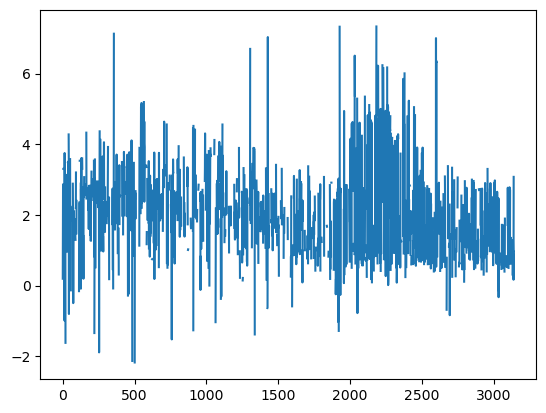

In [30]:
plt.plot(theoretical_results)

In [31]:
from scipy.ndimage import uniform_filter1d

def smooth_average(arr, window_size):
    arr = np.asarray(arr, dtype=float)
    
    # Replace inf with nan so all non-finite values are treated the same
    arr[~np.isfinite(arr)] = np.nan
    
    # Count finite values in each window
    counts = uniform_filter1d(np.isfinite(arr).astype(float), size=window_size, mode='nearest')
    
    # Replace nan with 0 for summing
    arr_no_nan = np.nan_to_num(arr, nan=0.0)
    
    # Compute sum in each window
    summed = uniform_filter1d(arr_no_nan, size=window_size, mode='nearest')
    
    # Avoid division by zero
    smoothed = summed / np.maximum(counts, 1)
    
    return smoothed

In [32]:
len(theoretical_results)

3142

In [40]:
smoothed_theoretical = smooth_average(theoretical_results, window_size=100)

In [43]:
len(smoothed_theoretical)

3142

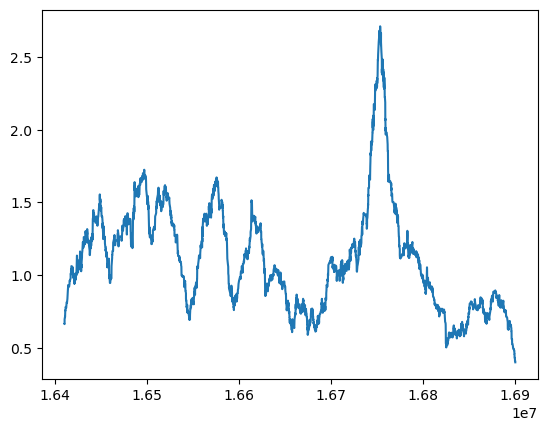

In [50]:
plt.plot(full_vcf_pos_filtered[snp_window_size-1:], smoothed_theoretical)

In [27]:
empirical_results = []
for i in range(len(snp_slides)):
    snp_window = snp_slides[i][0]
    pos_window = pos_slides[i]
    result = sample_scct_phased(snp_window, central_snp=None, theoretical=False, gts_pos=pos_window, full_vcf_gts=full_vcf_gts_filtered, full_vcf_pos=full_vcf_pos_filtered, set_alpha_1=False)   
    empirical_results.append(result)

empirical ratio: 0.006909132422263342
empirical ratio: 0.1745905756779334
empirical ratio: 0.003814983948140877
empirical ratio: 0.0008723383632662807
empirical ratio: 0.003679329375841599
empirical ratio: 0.003679329375841599
empirical ratio: 0.000922029410374013
empirical ratio: 0.0011113738472452116
empirical ratio: 0.0008983663916404644
empirical ratio: 0.0008983663916404644
empirical ratio: 0.000926762148385968
empirical ratio: 0.599013456304808
empirical ratio: 0.15637098867470867
empirical ratio: 0.002246579233937787
empirical ratio: 0.004317430796565982
empirical ratio: 0.0008794367822070081
empirical ratio: 0.0011752937643216758
empirical ratio: 0.8104216514216985
empirical ratio: 0.42021912216866497
empirical ratio: 0.005882786197786115
empirical ratio: 0.0009125640686172527
empirical ratio: 0.08055515847083809
empirical ratio: 0.0008155546362508126
empirical ratio: 0.0009243957737854598
empirical ratio: 0.8085680445035469
empirical ratio: 0.0008865353018357191
empirical rati

/tmp/ipykernel_1129/183703059.py:40: RuntimeWarning: divide by zero encountered in log
  S = np.log(sum_D/(ratio_alpha*sum_C))


empirical ratio: 0.004467547997076994
empirical ratio: 0.0012415897078125555
empirical ratio: 0.07013206326093112
empirical ratio: 0.002619226925463338
empirical ratio: 0.001030893709183939
empirical ratio: 0.0011752937643216758
empirical ratio: 0.0009007326431656615
empirical ratio: 0.0008960001513034556
empirical ratio: 0.004467547997076994
empirical ratio: 0.0024008239514152784
empirical ratio: 0.07966475203281063
empirical ratio: 0.4615751328271278
empirical ratio: 0.0012415897078125555
empirical ratio: 0.002246579233937787
empirical ratio: 0.004467547997076994
empirical ratio: 0.003646027181630471
empirical ratio: 0.8064053231062273
empirical ratio: 0.0027070874533720174
empirical ratio: 0.0012202793399140128
empirical ratio: 0.002170660808801947
empirical ratio: 0.0012344861510519146
empirical ratio: 0.0009030989058791266
empirical ratio: 0.0008865353018357191
empirical ratio: 0.0033272980633418966
empirical ratio: 0.0018220582632708549
empirical ratio: 0.001180028897701663
empir

/tmp/ipykernel_1129/183703059.py:35: RuntimeWarning: divide by zero encountered in scalar divide
  ratio_alpha = sum_D_full / sum_C_full
/tmp/ipykernel_1129/183703059.py:40: RuntimeWarning: invalid value encountered in scalar multiply
  S = np.log(sum_D/(ratio_alpha*sum_C))


empirical ratio: 0.0012700049428497776
empirical ratio: 0.00469639547494346
empirical ratio: 0.0009007326431656615
empirical ratio: 0.001092436179972949
empirical ratio: 0.0009007326431656615
empirical ratio: 0.000877070631372651
empirical ratio: 0.0012415897078125555
empirical ratio: 0.0005837546056347682
empirical ratio: 0.14678690265870392
empirical ratio: 0.09172714752170347
empirical ratio: 0.08933833274572224
empirical ratio: 0.0012415897078125555
empirical ratio: 0.0026405969880616597
empirical ratio: 0.003814983948140877
empirical ratio: 0.003814983948140877
empirical ratio: 0.002002257865252306
empirical ratio: 0.0011445164890774345
empirical ratio: 0.0012415897078125555
empirical ratio: 0.0027070874533720174
empirical ratio: 0.000877070631372651
empirical ratio: 0.07919701608976205
empirical ratio: 0.004539048152348774
empirical ratio: 0.07919701608976205
empirical ratio: 0.015887794401718117
empirical ratio: 0.003315409425810901
empirical ratio: 0.004467547997076994
empirica

/tmp/ipykernel_1129/183703059.py:40: RuntimeWarning: divide by zero encountered in scalar divide
  S = np.log(sum_D/(ratio_alpha*sum_C))


empirical ratio: 3.768276033263001
empirical ratio: 3.815195469617037
empirical ratio: 0.0012676399429562026
empirical ratio: 3.815195469617037
empirical ratio: 3.815195469617037
empirical ratio: 0.0009078314648711778
empirical ratio: 0.0010427282120639635
empirical ratio: 0.015249546758242286
empirical ratio: 3.773069190630012
empirical ratio: 3.79542695035461
empirical ratio: 0.002042579377758843
empirical ratio: 3.7951004754286233
empirical ratio: 0.0008889014974207672
empirical ratio: 0.0014026340189603951
empirical ratio: 0.09035972334917507
empirical ratio: 3.8160185987145008
empirical ratio: 3.679874199906979
empirical ratio: 3.679874199906979
empirical ratio: 0.09517341302182378
empirical ratio: 0.0012960536585135117
empirical ratio: 3.6604285446465004
empirical ratio: 3.679874199906979
empirical ratio: 0.0008841691174384628
empirical ratio: 0.0008889014974207672
empirical ratio: 31.68990868286643
empirical ratio: 0.006435156350289309
empirical ratio: 0.0009456935480057687
empi

In [28]:
empirical_results

[-1.273346563499274,
 0.913193317197279,
 0.8663922990713119,
 -1.419670184850831,
 0.8295092264984031,
 0.8295092264984031,
 -inf,
 -0.33313084984116414,
 -inf,
 -1.584761848561381,
 -inf,
 1.2902437325679423,
 -1.5907333345925854,
 0.9244592719583457,
 0.4826282182393782,
 -1.5439391149659227,
 -1.1277412291593074,
 1.8018996975445876,
 1.0898355503957742,
 -3.3744437903403557,
 -inf,
 0.718465581511504,
 1.0608372187329012,
 -1.464469439445611,
 1.776495159212984,
 -1.4765260582479505,
 0.4950808141865301,
 -1.500450909994961,
 0.9817421542789719,
 0.8311871616007853,
 0.7112301124860537,
 -1.1694867902893498,
 -0.9404975369054813,
 0.5186031475679715,
 -1.4134335030919496,
 -1.1810694791734753,
 1.3418888131407447,
 0.6147323909685447,
 1.1923746407305054,
 0.924795024263108,
 1.0924117784216272,
 1.4504894530103463,
 1.3662706737087273,
 -2.7494585551893027,
 2.32149680447705,
 -inf,
 0.5337536569374501,
 0.46000698252009,
 0.4160806035654756,
 -1.4700205067635452,
 -0.75856981441

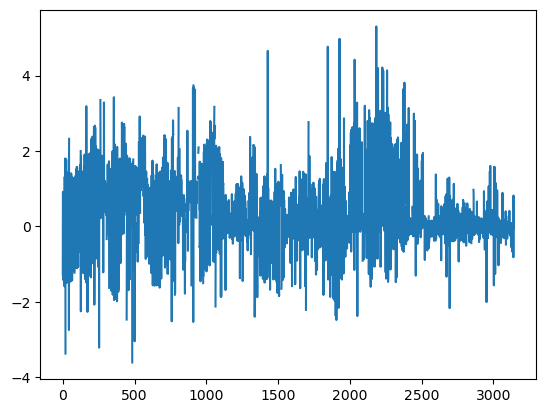

In [29]:
plt.plot(empirical_results)

In [51]:
smoothed_empirical = smooth_average(empirical_results, window_size=100)

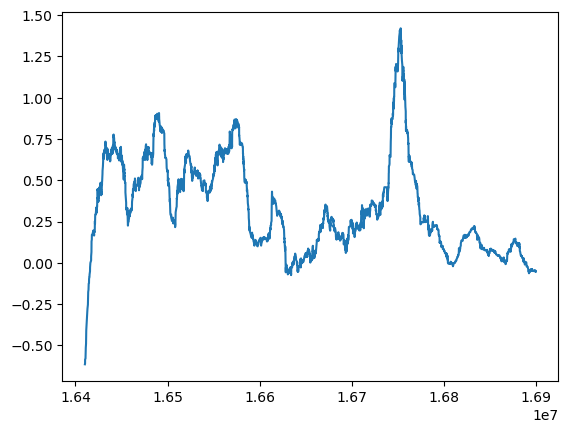

In [52]:
plt.plot(full_vcf_pos_filtered[snp_window_size-1:], smoothed_empirical)